Original DataFrame shape: (10815, 6)
Shape of X (inputs): (10801, 42)
Shape of y (targets): (10801, 7)

Training samples: 8465
Validation samples: 2336

Training XGBoost models for each forecast day...

--- XGBoost Model Performance on Validation Set ---
Day 1 Ahead -> MAE: 0.2549 m, RMSE: 0.4516 m, R²: 0.6518
Day 2 Ahead -> MAE: 0.3297 m, RMSE: 0.5572 m, R²: 0.4687
Day 3 Ahead -> MAE: 0.3678 m, RMSE: 0.6122 m, R²: 0.3566
Day 4 Ahead -> MAE: 0.3912 m, RMSE: 0.6365 m, R²: 0.3014
Day 5 Ahead -> MAE: 0.4031 m, RMSE: 0.6516 m, R²: 0.2648
Day 6 Ahead -> MAE: 0.4104 m, RMSE: 0.6611 m, R²: 0.2410
Day 7 Ahead -> MAE: 0.4174 m, RMSE: 0.6657 m, R²: 0.2291

Analyzing Feature Importances...


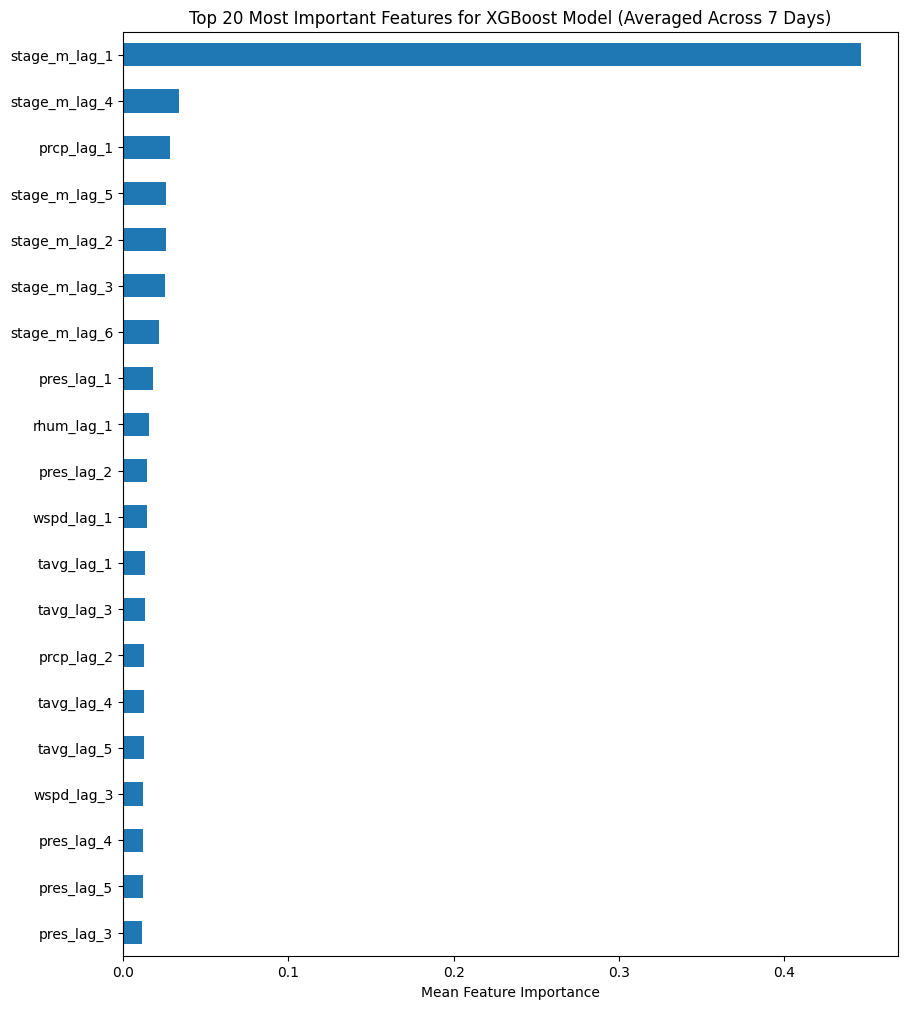

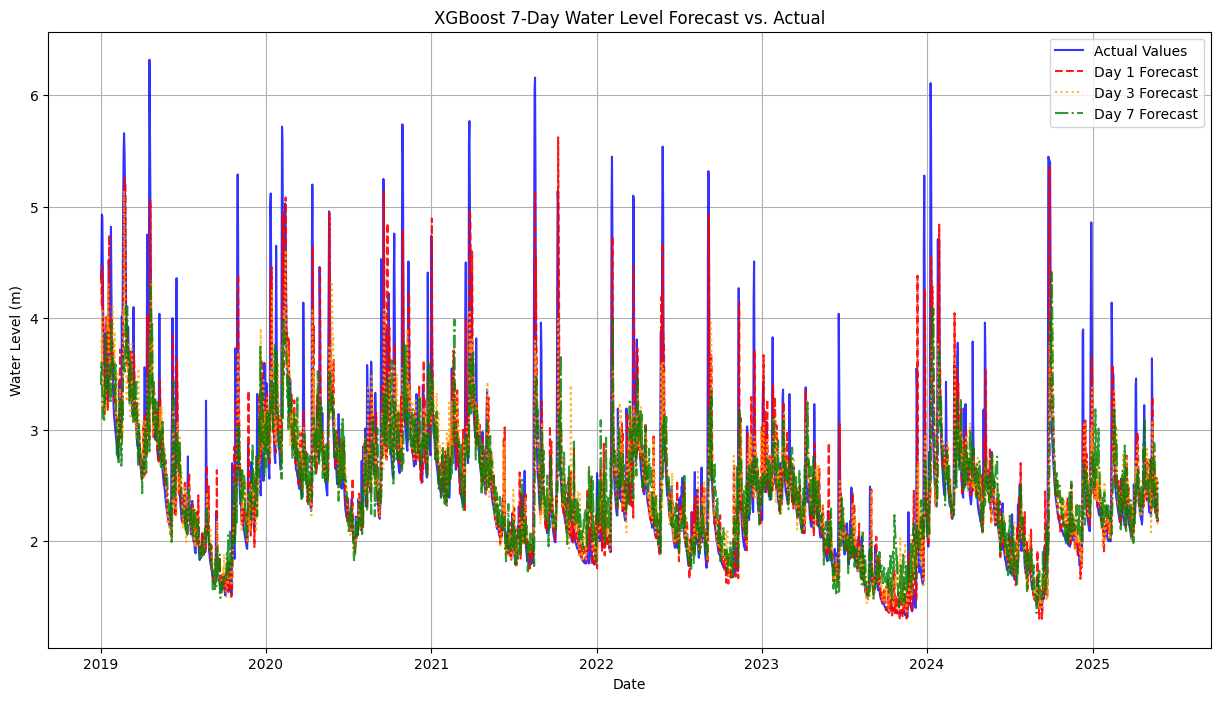

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
import matplotlib.pyplot as plt
import joblib # For saving the scaler

# 1. Load and Prepare Data
df = pd.read_csv('combined_dataset.csv', index_col='datetime', parse_dates=True)
print("Original DataFrame shape:", df.shape)

# 2. XGBoost Feature Engineering ## NEW CORE LOGIC ##

N_PAST = 7    # How many days of history to use as features
N_FUTURE = 7  # How many days to predict

# --- Create Lagged Input Features (X) ---
df_features = pd.DataFrame()
for i in range(N_PAST, 0, -1):
    for col in df.columns:
        df_features[f'{col}_lag_{i}'] = df[col].shift(i)

# --- Create Future Target Features (y) ---
df_targets = pd.DataFrame()
for i in range(1, N_FUTURE + 1):
    df_targets[f'target_day_{i}'] = df['stage_m'].shift(-i)

# --- Combine and clean data ---
df_full = pd.concat([df_features, df_targets], axis=1)
df_full.dropna(inplace=True) # Drop rows with NaN from shifting

# Separate X and y
feature_cols = [col for col in df_full.columns if 'lag' in col]
target_cols = [col for col in df_full.columns if 'target' in col]

X = df_full[feature_cols]
y = df_full[target_cols]

print("Shape of X (inputs):", X.shape)
print("Shape of y (targets):", y.shape)

# 3. Split Data
# Use the original DataFrame's index to find the split point
split_date_train_end = '2019-01-01'
train_indices = X.index <= split_date_train_end
val_indices = ~train_indices # Everything after the training period

X_train, X_val = X[train_indices], X[val_indices]
y_train, y_val = y[train_indices], y[val_indices]

print(f"\nTraining samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")

# 4. Scale Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
joblib.dump(scaler, 'xgboost_scaler.joblib') # Save the scaler for later use

# 5. Build and Train the XGBoost Model
# Instantiate the core XGBoost regressor
xgb_regressor = xgb.XGBRegressor(
    n_estimators=1000,         # High number, will be stopped by early stopping
    learning_rate=0.05,
    objective='reg:squarederror',
    n_jobs=-1,                 # Use all available CPU cores
    random_state=42
)

# Wrap it in MultiOutputRegressor
multioutput_model = MultiOutputRegressor(estimator=xgb_regressor)

# Train the model with early stopping
# Note: XGBoost early stopping requires a slightly different approach with the wrapper
# We fit one model at a time within the wrapper to leverage early stopping
# This is a bit more complex but ensures optimal training for each forecast day.
# (A simpler multioutput_model.fit(X_train_scaled, y_train) would work but without early stopping)

print("\nTraining XGBoost models for each forecast day...")
# This approach trains one model per output, which is standard for MultiOutputRegressor
multioutput_model.fit(X_train_scaled, y_train)

# 6. Evaluation
print("\n--- XGBoost Model Performance on Validation Set ---")
predictions = multioutput_model.predict(X_val_scaled)

# The output `predictions` is already a numpy array of shape (samples, 7)
for i in range(N_FUTURE):
    day = i + 1
    # Get true values for the day, y_val is a DataFrame so we use .iloc
    y_true_day = y_val.iloc[:, i]
    # Get predicted values for the day
    y_pred_day = predictions[:, i]

    mae = mean_absolute_error(y_true_day, y_pred_day)
    rmse = np.sqrt(mean_squared_error(y_true_day, y_pred_day))
    r2 = r2_score(y_true_day, y_pred_day)
    print(f"Day {day} Ahead -> MAE: {mae:.4f} m, RMSE: {rmse:.4f} m, R²: {r2:.4f}")


# 7. Explainability (XAI) - Feature Importance
print("\nAnalyzing Feature Importances...")
# We can average the importances from the model for each day's forecast
feature_importances = pd.DataFrame(
    {f'day_{i+1}': model.feature_importances_ for i, model in enumerate(multioutput_model.estimators_)}
    , index=X.columns
)
feature_importances['mean_importance'] = feature_importances.mean(axis=1)
feature_importances.sort_values('mean_importance', ascending=False, inplace=True)

plt.figure(figsize=(10, 12))
feature_importances['mean_importance'].head(20).plot(kind='barh')
plt.title('Top 20 Most Important Features for XGBoost Model (Averaged Across 7 Days)')
plt.xlabel('Mean Feature Importance')
plt.gca().invert_yaxis()
plt.show()

# 8. Visualization
plt.figure(figsize=(15, 8))
plt.plot(y_val.index, y_val.iloc[:, 0], label='Actual Values', color='blue', alpha=0.8)
plt.plot(y_val.index, predictions[:, 0], label='Day 1 Forecast', color='red', linestyle='--', alpha=0.9)
plt.plot(y_val.index, predictions[:, 2], label='Day 3 Forecast', color='orange', linestyle=':', alpha=0.8)
plt.plot(y_val.index, predictions[:, 6], label='Day 7 Forecast', color='green', linestyle='-.', alpha=0.8)
plt.title('XGBoost 7-Day Water Level Forecast vs. Actual')
plt.xlabel('Date')
plt.ylabel('Water Level (m)')
plt.legend()
plt.grid(True)
plt.show()